In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your CSV file
csv_file_path = '/home/aycaaktas/PURE/DATAWITHBB/DATA/all-processed.csv'
df = pd.read_csv(csv_file_path)

# Select a subset of the dataset
subset_df = df.sample(n=1000, random_state=42)  # Use 1000 samples for example

# Split the subset into training and validation sets
train_df, val_df = train_test_split(subset_df, test_size=0.2, random_state=42)

# Function to convert DataFrame to COCO format
def convert_to_coco_format(df):
    images = []
    annotations = []
    categories = []

    category_id = 1  # Assuming a single category (plants)
    annotation_id = 1  # Unique annotation ID

    for _, row in df.iterrows():
        image_id = row['image_name']
        image_path = row['image_path']
        bounding_box = eval(row['bounding_box']) if pd.notnull(row['bounding_box']) else []

        # Append image info
        images.append({
            'file_name': image_path,
            'height': 800,  # Assuming a fixed height
            'width': 800,  # Assuming a fixed width
            'id': image_id
        })

        # Append annotation info if bounding box exists
        if bounding_box:
            annotations.append({
                'area': (bounding_box[2] - bounding_box[0]) * (bounding_box[3] - bounding_box[1]),
                'iscrowd': 0,
                'image_id': image_id,
                'bbox': bounding_box,
                'category_id': category_id,
                'id': annotation_id
            })
            annotation_id += 1

    # Append category info
    categories.append({
        'id': category_id,
        'name': 'plant'
    })

    coco_format = {
        'images': images,
        'annotations': annotations,
        'categories': categories
    }
    return coco_format

# Convert train and validation sets to COCO format
train_coco_format = convert_to_coco_format(train_df)
val_coco_format = convert_to_coco_format(val_df)


In [13]:
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch

class PlantDataset(Dataset):
    def __init__(self, annotations, transforms=None):
        self.annotations = annotations
        self.transforms = transforms

    def __getitem__(self, idx):
        img_path = self.annotations['images'][idx]['file_name']
        img = Image.open(img_path).convert("RGB")
        img_id = self.annotations['images'][idx]['id']

        boxes = []
        labels = []

        for ann in self.annotations['annotations']:
            if ann['image_id'] == img_id:
                boxes.append(ann['bbox'])
                labels.append(ann['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {'boxes': boxes, 'labels': labels}

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.annotations['images'])

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

train_dataset = PlantDataset(train_coco_format, get_transform(train=True))
val_dataset = PlantDataset(val_coco_format, get_transform(train=False))

# Adjust batch size for smaller dataset
batch_size = 2

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))


In [17]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms as T
import os
import time

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_start_time = time.time()
    for batch_idx, (images, targets) in enumerate(train_data_loader):
        batch_start_time = time.time()
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Filter out images without bounding boxes
        images = [image for image, target in zip(images, targets) if target['boxes'].nelement() > 0]
        targets = [target for target in targets if target['boxes'].nelement() > 0]

        if len(images) == 0:
            continue

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()
        batch_time = time.time() - batch_start_time
        print(f"Batch {batch_idx + 1}/{len(train_data_loader)} - Loss: {losses.item():.4f} - Time: {batch_time:.2f}s")

    epoch_time = time.time() - epoch_start_time
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss / len(train_data_loader):.4f} - Time: {epoch_time:.2f}s")

    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(val_data_loader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Filter out images without bounding boxes
            images = [image for image, target in zip(images, targets) if target['boxes'].nelement() > 0]
            targets = [target for target in targets if target['boxes'].nelement() > 0]

            if len(images) == 0:
                continue

            # Switch model to training mode for loss computation
            model.train()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            model.eval()

            val_loss += losses.item()

        print(f"Validation Loss after epoch [{epoch+1}]: {val_loss / len(val_data_loader):.4f}")

    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss
    }, 'model_checkpoint.pth')


Batch 1/400 - Loss: 0.0863 - Time: 0.20s
Batch 2/400 - Loss: 0.1014 - Time: 0.15s
Batch 3/400 - Loss: 0.0955 - Time: 0.15s
Batch 4/400 - Loss: 0.1464 - Time: 0.15s
Batch 5/400 - Loss: 0.2038 - Time: 0.15s
Batch 6/400 - Loss: 0.0815 - Time: 0.15s
Batch 7/400 - Loss: 0.1308 - Time: 0.16s
Batch 8/400 - Loss: 0.2033 - Time: 0.15s
Batch 9/400 - Loss: 0.1752 - Time: 0.15s
Batch 10/400 - Loss: 0.0845 - Time: 0.15s
Batch 11/400 - Loss: 0.1136 - Time: 0.15s
Batch 12/400 - Loss: 0.1394 - Time: 0.16s
Batch 13/400 - Loss: 0.1470 - Time: 0.17s
Batch 14/400 - Loss: 0.0736 - Time: 0.14s
Batch 15/400 - Loss: 0.0733 - Time: 0.16s
Batch 16/400 - Loss: 0.1208 - Time: 0.14s
Batch 17/400 - Loss: 0.1849 - Time: 0.15s
Batch 18/400 - Loss: 0.1560 - Time: 0.15s
Batch 19/400 - Loss: 0.0981 - Time: 0.15s
Batch 20/400 - Loss: 0.1362 - Time: 0.14s
Batch 21/400 - Loss: 0.0824 - Time: 0.15s
Batch 22/400 - Loss: 0.0771 - Time: 0.15s
Batch 23/400 - Loss: 0.0550 - Time: 0.15s
Batch 24/400 - Loss: 0.1769 - Time: 0.15s
B

Batch 1/400 - Loss: 0.2299 - Time: 0.18s
Batch 2/400 - Loss: 0.2219 - Time: 0.15s
Batch 3/400 - Loss: 0.2410 - Time: 0.15s
Batch 4/400 - Loss: 0.0865 - Time: 0.15s
Batch 5/400 - Loss: 0.0983 - Time: 0.15s
Batch 6/400 - Loss: 0.1050 - Time: 0.15s
Batch 8/400 - Loss: 0.1143 - Time: 0.15s
Batch 9/400 - Loss: 0.1522 - Time: 0.15s
Batch 10/400 - Loss: 0.0837 - Time: 0.17s
Batch 11/400 - Loss: 0.1490 - Time: 0.15s
Batch 12/400 - Loss: 0.1882 - Time: 0.16s
Batch 13/400 - Loss: 0.0953 - Time: 0.14s
Batch 14/400 - Loss: 0.0961 - Time: 0.16s
Batch 15/400 - Loss: 0.0693 - Time: 0.15s
Batch 16/400 - Loss: 0.0710 - Time: 0.15s
Batch 17/400 - Loss: 0.0837 - Time: 0.15s
Batch 18/400 - Loss: 0.0745 - Time: 0.15s
Batch 19/400 - Loss: 0.0857 - Time: 0.15s
Batch 20/400 - Loss: 0.1050 - Time: 0.14s
Batch 21/400 - Loss: 0.1378 - Time: 0.14s
Batch 22/400 - Loss: 0.0762 - Time: 0.14s
Batch 23/400 - Loss: 0.1260 - Time: 0.14s
Batch 24/400 - Loss: 0.1676 - Time: 0.15s
Batch 25/400 - Loss: 0.1058 - Time: 0.15s


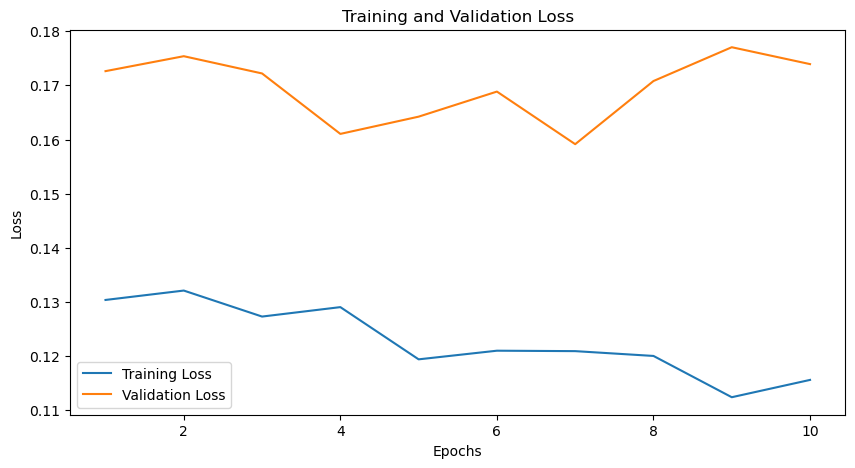

In [19]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms as T
import os
import time
import matplotlib.pyplot as plt

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Set the number of epochs
num_epochs = 10

# Lists to store losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_start_time = time.time()
    for batch_idx, (images, targets) in enumerate(train_data_loader):
        batch_start_time = time.time()
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Filter out images without bounding boxes
        images = [image for image, target in zip(images, targets) if target['boxes'].nelement() > 0]
        targets = [target for target in targets if target['boxes'].nelement() > 0]

        if len(images) == 0:
            continue

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()
        batch_time = time.time() - batch_start_time
        print(f"Batch {batch_idx + 1}/{len(train_data_loader)} - Loss: {losses.item():.4f} - Time: {batch_time:.2f}s")

    epoch_loss /= len(train_data_loader)
    train_losses.append(epoch_loss)
    epoch_time = time.time() - epoch_start_time
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f} - Time: {epoch_time:.2f}s")

    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(val_data_loader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Filter out images without bounding boxes
            images = [image for image, target in zip(images, targets) if target['boxes'].nelement() > 0]
            targets = [target for target in targets if target['boxes'].nelement() > 0]

            if len(images) == 0:
                continue

            # Switch model to training mode for loss computation
            model.train()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            model.eval()

            val_loss += losses.item()

    val_loss /= len(val_data_loader)
    val_losses.append(val_loss)
    print(f"Validation Loss after epoch [{epoch+1}]: {val_loss:.4f}")

    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss
    }, 'model_checkpoint.pth')

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Batch 1/400 - Loss: 0.1421 - Time: 0.19s
Batch 2/400 - Loss: 0.0833 - Time: 0.16s
Batch 3/400 - Loss: 0.1257 - Time: 0.16s
Batch 4/400 - Loss: 0.1145 - Time: 0.15s
Batch 5/400 - Loss: 0.0930 - Time: 0.15s
Batch 6/400 - Loss: 0.0952 - Time: 0.15s
Batch 7/400 - Loss: 0.0674 - Time: 0.14s
Batch 8/400 - Loss: 0.0830 - Time: 0.14s
Batch 9/400 - Loss: 0.0561 - Time: 0.15s
Batch 10/400 - Loss: 0.0990 - Time: 0.15s
Batch 11/400 - Loss: 0.0985 - Time: 0.16s
Batch 12/400 - Loss: 0.1680 - Time: 0.16s
Batch 13/400 - Loss: 0.1623 - Time: 0.14s
Batch 14/400 - Loss: 0.0768 - Time: 0.15s
Batch 15/400 - Loss: 0.1202 - Time: 0.17s
Batch 16/400 - Loss: 0.0755 - Time: 0.15s
Batch 17/400 - Loss: 0.1038 - Time: 0.16s
Batch 18/400 - Loss: 0.1200 - Time: 0.15s
Batch 19/400 - Loss: 0.1456 - Time: 0.16s
Batch 20/400 - Loss: 0.0882 - Time: 0.15s
Batch 21/400 - Loss: 0.2172 - Time: 0.15s
Batch 22/400 - Loss: 0.0864 - Time: 0.15s
Batch 23/400 - Loss: 0.0868 - Time: 0.16s
Batch 24/400 - Loss: 0.1210 - Time: 0.15s
B

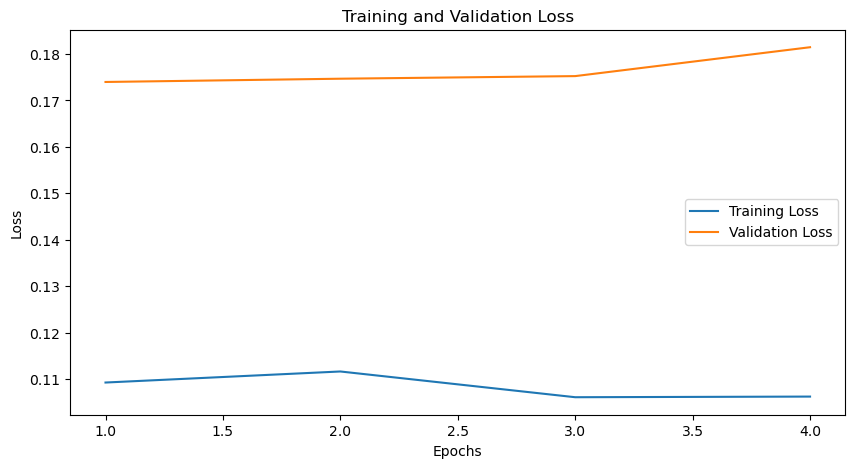

In [20]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms as T
import os
import time
import matplotlib.pyplot as plt

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Set the number of epochs
num_epochs = 10

# Early stopping parameters
early_stopping_patience = 3
best_val_loss = float('inf')
patience_counter = 0

# Lists to store losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_start_time = time.time()
    for batch_idx, (images, targets) in enumerate(train_data_loader):
        batch_start_time = time.time()
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Filter out images without bounding boxes
        images = [image for image, target in zip(images, targets) if target['boxes'].nelement() > 0]
        targets = [target for target in targets if target['boxes'].nelement() > 0]

        if len(images) == 0:
            continue

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()
        batch_time = time.time() - batch_start_time
        print(f"Batch {batch_idx + 1}/{len(train_data_loader)} - Loss: {losses.item():.4f} - Time: {batch_time:.2f}s")

    epoch_loss /= len(train_data_loader)
    train_losses.append(epoch_loss)
    epoch_time = time.time() - epoch_start_time
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f} - Time: {epoch_time:.2f}s")

    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(val_data_loader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Filter out images without bounding boxes
            images = [image for image, target in zip(images, targets) if target['boxes'].nelement() > 0]
            targets = [target for target in targets if target['boxes'].nelement() > 0]

            if len(images) == 0:
                continue

            # Switch model to training mode for loss computation
            model.train()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            model.eval()

            val_loss += losses.item()

    val_loss /= len(val_data_loader)
    val_losses.append(val_loss)
    print(f"Validation Loss after epoch [{epoch+1}]: {val_loss:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss
        }, 'best_model_checkpoint.pth')
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered")
        break

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
